In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import re, string , unicodedata
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import nltk
nltk.download('stopwords')
#nltk.download()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_json('/content/drive/MyDrive/Sarcasm Detection/Sarcasm_Headlines_Dataset.json', lines = True, orient = 'columns')
df_v2 = pd.read_json('/content/drive/MyDrive/Sarcasm Detection/Sarcasm_Headlines_Dataset_v2.json', lines = True, orient = 'columns')
df = pd.concat([df, df_v2])
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
print(df.isna().sum())
print('')
df.drop(columns= ['article_link'], inplace= True)
df.info()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
# convert to lowercase
df['headline'] = df['headline'].apply(lambda x: x.lower())

# remove punctuation
df['headline'] = df['headline'].apply(lambda x: ' '.join(
    word.strip(string.punctuation) for word in x.split()))

# remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
headline = []
for sentence in df['headline']:
    filtered_list = []
    for word in sentence.split():
        if word not in stopwords:
            filtered_list.append(word)
    join_string = ' '.join([str(i) for i in filtered_list])
    headline.append(join_string)
df['headline'] = headline

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.1)

train_sentences = list(train_data['headline'])
train_labels = list(train_data['is_sarcastic'])

test_sentences = list(test_data['headline'])
test_labels = list(test_data['is_sarcastic'])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


25.0

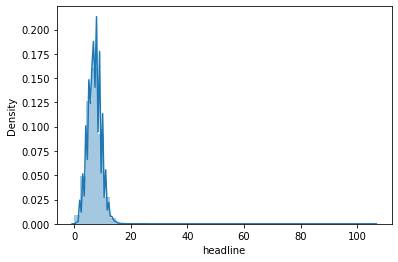

In [8]:
import seaborn as sns
headline_lengths = df['headline'].apply(lambda x: len(x.split())) 
sns.distplot(headline_lengths)
headline_lengths.quantile(0.9999)
### 99.99% sentences have less than 25 or less words

In [9]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
embedding_dim = 128
# as noted from above plot and data we see that 99.99% of headlines are of length 25 or less
# hence it is safe to assume that the suitable max length of a headline is 31
max_length = 32

oov_tok = '<OOV>'
trunc_type = 'post'


tokenizer = Tokenizer(oov_token= oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_idx = tokenizer.word_index #dict with vocab words
vocab_size = len(word_idx)

training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen= max_length, padding= 'post', truncating= trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen= max_length, padding= 'post', truncating= trunc_type)

In [11]:
print(train_sentences[0])
print(training_sequences[0])
print(training_padded[0])

detroit tourism board's hidden detroit campaign results 24 deaths
[2188, 6332, 14821, 2856, 2188, 73, 881, 2014, 2331]
[ 2188  6332 14821  2856  2188    73   881  2014  2331     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [12]:
training_padded = np.array(training_padded)
print(training_padded.shape)

testing_padded = np.array(testing_padded)
print(testing_padded.shape)

(49795, 32)
(5533, 32)


In [13]:
model1d = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length= max_length),
    keras.layers.Conv1D(128, 1, activation= 'relu'),
    keras.layers.MaxPooling1D(2, padding= 'same'),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation= 'relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l1(0.01), activation= 'sigmoid')
])

model1d.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model1d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 128)           3506688   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           16512     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dropout (Dropout)           (None, 100)               0

In [14]:
history = model1d.fit(training_padded, train_labels, epochs= 10, validation_split= 0.2)
res = (model1d.predict(testing_padded) > 0.5).astype(int).reshape(-1)
print("Accuracy", accuracy_score(y_true = test_labels, y_pred = res))
print("Recall", recall_score(y_true = test_labels, y_pred = res))
print("Precision", + precision_score(y_true = test_labels, y_pred = res))
print("F1-score", + f1_score(y_true = test_labels, y_pred = res))

Epoch 1/10
1245/1245 [==============================] - 27s 10ms/step - loss: 1.0206 - accuracy: 0.7985 - val_loss: 0.4265 - val_accuracy: 0.8783
Epoch 2/10
1245/1245 [==============================] - 12s 10ms/step - loss: 0.3286 - accuracy: 0.9298 - val_loss: 0.3721 - val_accuracy: 0.9076
Epoch 3/10
1245/1245 [==============================] - 12s 10ms/step - loss: 0.2414 - accuracy: 0.9661 - val_loss: 0.3569 - val_accuracy: 0.9238
Epoch 4/10
1245/1245 [==============================] - 12s 9ms/step - loss: 0.1995 - accuracy: 0.9813 - val_loss: 0.3542 - val_accuracy: 0.9278
Epoch 5/10
1245/1245 [==============================] - 12s 10ms/step - loss: 0.1779 - accuracy: 0.9890 - val_loss: 0.3612 - val_accuracy: 0.9341
Epoch 6/10
1245/1245 [==============================] - 12s 10ms/step - loss: 0.1675 - accuracy: 0.9919 - val_loss: 0.3486 - val_accuracy: 0.9352
Epoch 7/10
1245/1245 [==============================] - 12s 10ms/step - loss: 0.1600 - accuracy: 0.9947 - val_loss: 0.3730 - 

# **Using Glove Embeddings**

In [12]:
embedding_dim = 100
embeddings_idx = {}
with open('/content/drive/MyDrive/Sarcasm Detection/glove.6B.100d.txt', encoding= 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype= 'float32')
        embeddings_idx[word] = coefs
        
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for key in sorted(word_idx, key= word_idx.get)[:vocab_size]:
    embedding_vec = embeddings_idx.get(key)
    if embedding_vec is not None:
        embedding_matrix[word_idx[key]] = embedding_vec

In [13]:
for key in sorted(word_idx, key=word_idx.get)[:10]:
  print(key,end=' ')
  print(word_idx.get(key))

<OOV> 1
new 2
trump 3
man 4
one 5
report 6
year 7
area 8
u 9
day 10


In [14]:
for key in sorted(word_idx, key=word_idx.get)[:10]:
  print(key,end=' ')
  print(embeddings_idx.get(key))

<OOV> None
new [-4.3959e-02  1.8936e-01  6.6110e-01 -4.9007e-01  3.2211e-01 -3.4161e-01
 -6.8480e-02  3.1364e-01 -7.1142e-01  5.7436e-01 -3.3588e-01 -5.2279e-01
 -3.9075e-01 -8.9694e-02  4.6371e-01 -3.5610e-01  8.4576e-01 -2.6188e-02
 -1.9328e-01 -8.3846e-02  3.1806e-01 -1.9812e-01  3.0009e-01  6.9189e-02
  5.4470e-01 -5.9193e-01  5.4221e-01 -6.2876e-01 -5.3447e-01  4.2334e-01
  3.0869e-02  9.7164e-01 -5.6222e-01  4.5752e-02 -5.7100e-01  8.0185e-02
 -8.1434e-02 -6.0260e-01  1.6466e-01 -4.0281e-01 -4.7701e-01 -5.1950e-01
  1.2777e-01 -4.3775e-01  2.6602e-01  4.8752e-01 -6.0220e-02 -5.2622e-01
  3.7687e-01 -1.8007e-01  3.0166e-02 -9.4577e-02  1.6330e-01  5.9041e-01
 -4.8877e-01 -3.4230e+00  1.3113e-01 -8.0386e-02  1.8978e+00  1.8857e-01
 -5.7300e-01  8.6358e-01  2.1116e-03  3.6060e-01  8.0475e-01 -1.3954e-01
 -5.3935e-02  3.8873e-01  3.0673e-01 -3.1395e-01  8.3238e-02 -4.1737e-01
 -1.0998e+00 -8.8005e-01  2.1550e-01 -2.6132e-01 -1.0091e-01  7.9584e-02
 -1.2341e+00 -6.5281e-01  6.3363e-01

In [15]:
vocab_size = len(word_idx)

model2d = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embedding_dim, input_length= max_length, weights= [embedding_matrix]),
    keras.layers.Conv1D(128, 1, activation= 'relu'),
    keras.layers.MaxPooling1D(2, padding= 'same'),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation= 'relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l1(0.01), activation= 'sigmoid')
])

model2d.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model2d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           2739000   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           12928     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dropout (Dropout)           (None, 100)               0

In [16]:
history = model2d.fit(training_padded, train_labels, epochs= 10, validation_split= 0.2)
res = (model2d.predict(testing_padded) > 0.5).astype(int).reshape(-1)
print(accuracy_score(y_true = test_labels, y_pred = res))
print(recall_score(y_true = test_labels, y_pred = res))
print(precision_score(y_true = test_labels, y_pred = res))
print(f1_score(y_true = test_labels, y_pred = res))

Epoch 1/10
1245/1245 [==============================] - 18s 10ms/step - loss: 1.0420 - accuracy: 0.7951 - val_loss: 0.4904 - val_accuracy: 0.8453
Epoch 2/10
1245/1245 [==============================] - 11s 9ms/step - loss: 0.3512 - accuracy: 0.9233 - val_loss: 0.3614 - val_accuracy: 0.9121
Epoch 3/10
1245/1245 [==============================] - 11s 9ms/step - loss: 0.2447 - accuracy: 0.9652 - val_loss: 0.3371 - val_accuracy: 0.9271
Epoch 4/10
1245/1245 [==============================] - 11s 9ms/step - loss: 0.1999 - accuracy: 0.9822 - val_loss: 0.3339 - val_accuracy: 0.9339
Epoch 5/10
1245/1245 [==============================] - 11s 9ms/step - loss: 0.1813 - accuracy: 0.9884 - val_loss: 0.3481 - val_accuracy: 0.9365
Epoch 6/10
1245/1245 [==============================] - 12s 9ms/step - loss: 0.1683 - accuracy: 0.9923 - val_loss: 0.3545 - val_accuracy: 0.9360
Epoch 7/10
1245/1245 [==============================] - 14s 11ms/step - loss: 0.1651 - accuracy: 0.9929 - val_loss: 0.3428 - val_

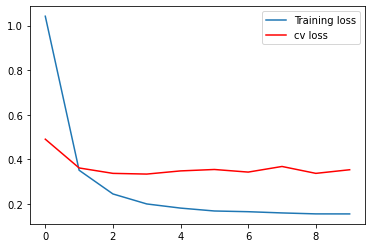

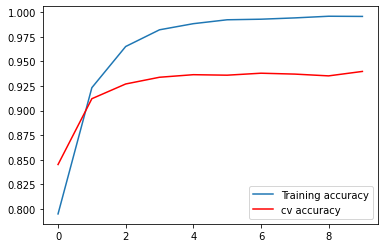

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='cv loss')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='cv accuracy')
plt.legend()